# **Twitter Sentiment Classification Project**

- [1. Introduction](#1-introduction)
  - [Recurrent Neural Networks](#recurrent-neural-networks)
  - [High Level Steps](#high-level-steps)
- [2. Dataset Loading](#2-dataset-loading)
- [3. A Simple RNN Model](#3-simple-rnn-model)
- [4. TextVectorization Layer and Custom Embeddings](#4-textvec-emb)
- [5. Custom Preprocessing and GloVe Embeddings](#5-preprocessing-and-glove)
- [6. The Final Bidirectional LSTM Model](#6-the-final-model)
  - [2 Bidirectional LSTM layers](#2-bidirectional-lstm-layers)
  - [Pooling](#pooling)
  - [Dense Layers](#dense-layers)
  - [Dropout Layers](#dropout-layers)
- [7. Simple Test with our own Tweets](#simple-test)

---

## **1. Introduction**

In this project, we tackle the **binary classification** of **Twitter messages** into **positive** and **negative** categories. We are provided with two separate directories containing labeled tweets:

- Directory **0**: Negative tweets
- Directory **1**: Positive tweets

Our approach focuses on a more detailed exploration of a single model family rather than broadly comparing multiple families, which could lead to overly generic solutions. By conducting a series of experiments, we aim to dig deeper into the specific characteristics of the chosen model family. This approach allows us to experiment with the architecture in a more targeted way.

### **Recurrent Neural Networks**

We chose to focus on experimenting with Recurrent Neural Networks (RNNs) for the sentiment analysis task. RNNs are particularly well-suited for processing sequential data, as they maintain a hidden state that captures the influence of previous input sequences. Tweets, being short and concise, often require understanding the flow of sentiment within a limited context. RNNs excel at this by processing one word at a time, retaining contextual information from previous words to identify patterns that signal positive or negative sentiment.

Although Transformers are the state-of-the-art for many NLP tasks, we specifically opted not to use them here. Transformers are optimized for modeling long-range dependencies and contextual relationships across entire documents. While highly effective, their self-attention mechanism can be unnecessary for short texts like tweets. Additionally, Transformers are computationally intensive, demanding significant resources for training and inference. For a simpler binary classification task, this added complexity can result in inefficiencies without a proportional gain in performance.

By choosing RNNs, we focus on a model that is both resource-efficient and well-matched to the specific demands of analyzing short texts, ensuring effective results without unnecessary computational overhead.

### **High Level Steps**

From a high-level view, the project will follow these two steps:

1. Build and evaluate a baseline RNN model to figure out the best embedding technique, trying out two different preprocessing strategies.
2. Starting from the baseline model, design and evaluate a more complex architecture.

---


In [ ]:
# Dependencies and some utility functions for the notebook
import os
import logging
import warnings
import math
import random
import re
import numpy as np
import tensorflow as tf
import pandas as pd
from rich.table import Table
from rich.console import Console
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import layers, models, preprocessing, callbacks, optimizers
import keras_tuner as kt

# Whether to enable debug mode
DEBUG = True

console = Console()

if not DEBUG:
    # Ignore warnings
    warnings.filterwarnings("ignore")
    # Removes info and warning messages from Tensorflow
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
    tf.get_logger().setLevel(logging.ERROR)

    os.environ["PYTHONWARNINGS"] = "ignore"

    logging.getLogger("tensorflow").setLevel(logging.ERROR)

else:
    # Check TensorFlow version
    console.print("TensorFlow version:", tf.__version__)

    # List physical devices
    physical_devices = tf.config.list_physical_devices("GPU")
    console.print("GPUs available:", len(physical_devices))

    if physical_devices:
        for gpu in physical_devices:
            console.print("GPU:", gpu.name)
    else:
        console.print("No GPU detected.")


def create_rich_table(data, headers, title="Table"):
    table = Table(title=title, show_lines=True)

    # Add headers to the table
    for header in headers:
        table.add_column(header, justify="center")

    # Add rows to the table
    for row in data:
        table.add_row(*map(str, row))

    return table


def print_best_hyperparameters(best_hp, model_name):
    best_hp_table_data = [(key, best_hp.get(key)) for key in best_hp.values]
    best_hyper_params_table = create_rich_table(
        best_hp_table_data,
        headers=["Hyperparameter", "Value"],
        title="Best Hyperparameters for " + model_name,
    )

    console.print(best_hyper_params_table)


def evaluate_model_and_print_results(model, model_name, test_x, test_y):

    # Get predictions from the model
    preds = model.predict(test_x)

    # Round predictions to 0 or 1
    preds = (preds > 0.5).astype(int)

    # Calculate evaluation metrics
    accuracy = accuracy_score(test_y, preds)
    precision = precision_score(test_y, preds, average="binary")
    recall = recall_score(test_y, preds, average="binary")
    f1 = f1_score(test_y, preds, average="binary")

    # Prepare the results as a table
    eval_table_data = [
        ("Accuracy", f"{accuracy:.4f}"),
        ("Precision", f"{precision:.4f}"),
        ("Recall", f"{recall:.4f}"),
        ("F1-Score", f"{f1:.4f}"),
    ]

    evaluation_table = create_rich_table(
        eval_table_data,
        headers=["Metric", "Result"],
        title="Evaluation Results for " + model_name,
    )

    # Print the evaluation table
    console.print(evaluation_table)


# Plot metrics from training history
def plot_training_history(history):
    history_df = pd.DataFrame(history.history)

    plt.figure(figsize=(8, 4))
    for metric in history_df.columns:
        plt.plot(history_df[metric], label=metric)

    plt.title("Training Metrics over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()

TensorFlow version: 2.16.2

GPUs available: 1

GPU: /physical_device:GPU:0

## **2. Dataset Loading**

We loaded the dataset using the `text_dataset_from_directory` function and split it into 70% for training, 20% for validation, and 10% for testing.


In [ ]:
DATASET_DIR = "../TwitterParsed"

BATCH_SIZE = 32


def load_dataset(
    data_dir, batch_size=BATCH_SIZE, validation_split=0.2, test_split=0.1, seed=42
):
    # Training dataset
    train_ds = preprocessing.text_dataset_from_directory(
        data_dir,
        batch_size=batch_size,
        validation_split=validation_split + test_split,  # Total non-training data
        subset="training",
        seed=seed,
    )

    # Split with both validation and test sets
    val_and_test_ds = preprocessing.text_dataset_from_directory(
        data_dir,
        batch_size=batch_size,
        validation_split=validation_split + test_split,
        subset="validation",
        seed=seed,
    )

    # Further split into validation and test sets
    val_size = math.floor(
        (validation_split / (validation_split + test_split)) * len(val_and_test_ds)
    )

    val_ds = val_and_test_ds.take(val_size)
    test_ds = val_and_test_ds.skip(val_size)

    # Cache and prefetch datasets for better performance
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds


def prepare_test_ds_for_prediction(test_ds):
    test_data = []
    test_labels = []
    for text, label in test_ds.unbatch():
        test_data.append(text.numpy())
        test_labels.append(label.numpy())

    test_data = tf.convert_to_tensor(test_data)
    test_labels = np.array(test_labels)

    return test_data, test_labels


# Count dataset samples
def count_samples(dataset):
    return sum(1 for _ in dataset.unbatch())


def compute_class_distribution(dataset):
    neg_count = 0
    pos_count = 0
    for _, label in dataset.unbatch():
        if label.numpy() == 0:
            neg_count += 1
        else:
            pos_count += 1
    total = neg_count + pos_count
    neg_percent = (neg_count / total) * 100 if total > 0 else 0
    pos_percent = (pos_count / total) * 100 if total > 0 else 0
    return neg_count, pos_count, neg_percent, pos_percent


def create_dataset_summary_table(train_ds, val_ds, test_ds):
    train_count = count_samples(train_ds)
    val_count = count_samples(val_ds)
    test_count = count_samples(test_ds)
    total_count = train_count + val_count + test_count

    train_neg, train_pos, train_neg_percent, train_pos_percent = (
        compute_class_distribution(train_ds)
    )
    val_neg, val_pos, val_neg_percent, val_pos_percent = compute_class_distribution(
        val_ds
    )
    test_neg, test_pos, test_neg_percent, test_pos_percent = compute_class_distribution(
        test_ds
    )

    # Prepare the data for the table
    data = [
        [
            "Training",
            train_count,
            f"{train_neg_percent:.2f}%",
            f"{train_pos_percent:.2f}%",
        ],
        ["Validation", val_count, f"{val_neg_percent:.2f}%", f"{val_pos_percent:.2f}%"],
        ["Testing", test_count, f"{test_neg_percent:.2f}%", f"{test_pos_percent:.2f}%"],
        [
            "Total",
            total_count,
            f"{((train_neg + val_neg + test_neg) / total_count) * 100:.2f}%",
            f"{((train_pos + val_pos + test_pos) / total_count) * 100:.2f}%",
        ],
    ]

    # Headers for the table
    headers = ["Dataset", "Number of Tweets", "Negative %", "Positive %"]

    # Creeate a rich table
    rich_table = create_rich_table(data, headers, title="Dataset Summary")

    return rich_table


# Load dataset in training (70%), validation (20%), and test (10%) sets
train_ds, val_ds, test_ds = load_dataset(DATASET_DIR)
summary_table = create_dataset_summary_table(train_ds, val_ds, test_ds)
console.print(summary_table)

Found 149985 files belonging to 2 classes.
Using 104990 files for training.


2024-12-28 17:56:15.839501: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-28 17:56:15.839530: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-28 17:56:15.839544: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-28 17:56:15.839803: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-28 17:56:15.839816: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 149985 files belonging to 2 classes.
Using 44995 files for validation.


2024-12-28 17:56:26.662309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-28 17:56:28.378847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-28 17:56:30.493285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-28 17:56:36.315227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-28 17:56:38.002666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-28 17:56:40.672359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


                      Dataset Summary                      
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃  Dataset   ┃ Number of Tweets ┃ Negative % ┃ Positive % ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│  Training  │      104990      │   50.08%   │   49.92%   │
├────────────┼──────────────────┼────────────┼────────────┤
│ Validation │      30016       │   49.87%   │   50.13%   │
├────────────┼──────────────────┼────────────┼────────────┤
│  Testing   │      14979       │   49.76%   │   50.24%   │
├────────────┼──────────────────┼────────────┼────────────┤
│   Total    │      149985      │   50.01%   │   49.99%   │
└────────────┴──────────────────┴────────────┴────────────┘

## **3. A Simple RNN Model**

To create two distinct models employing different strategies for the Embedding layer, we defined a simple, reusable function. This function takes as input a model with a pre-defined Embedding layer and assumes the dataset has already been preprocessed and tokenized. As a result, the function can be utilized across both model configurations. The purpose of the built initial model is to identify the best embedding strategy. To achieve this, we keep the architecture relatively simple, with a more complex design planned for a later stage.

In the subsequent sections, where we’ll train different model configurations, we’ll intentionally limit the number of epochs. The goal at this stage is not to fully train the model but to evaluate and identify the best Embedding layer. Once we’ve determined the most effective embedding strategy, we will integrate it into the final model for further training and refinement.


In [3]:
# Construct a baseline LSTM model based on an existing model that includes a pre-defined `Embedding` layer.
# The primary purpose of this model is to evaluate the effectiveness of various embeddings.
def build_lstm_from_embedding_model(model):
    """
    Build a simple LSTM model from an existing model with an Embedding layer
    """
    # 1. Add a Bidirectional LSTM layer
    model.add(
        layers.Bidirectional(
            layers.LSTM(
                units=128,
                return_sequences=False,
            )
        )
    )
    # 2. Add some Dense layer
    model.add(layers.Dense(units=128, activation="sigmoid"))
    # 3: Final output layer for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # 4. Compile the model
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"],
    )

    return model

## **4. TextVectorization Layer and Custom Embeddings**

At this phase, we implement a simple model that leverages the Keras `TextVectorization` layer with an `Embedding` layer built on top. We decided to use the default behavior of the TextVectorization layer, where the text is split into words, each word is assigned a token, and the default standardization function (lowercasing and punctuation stripping) is applied.

In the next configuration, we will adopt a more customized preprocessing strategy tailored specifically for tweets and evaluate how it compares to this simpler and more generic approach.

One key advantage of this initial approach, beyond its simplicity, is that the vectorization logic is fully integrated within the RNN. This eliminates the need for separate preprocessing, as the entire pipeline is managed directly by the network. Additionally, the embedding layer can be trained in a more customized and cohesive manner on top of the vectorization layer.

We experimented with four different model configurations, varying the VOCAB_SIZE and MAX_SEQ_LENGTH parameters. Specifically, we tested the following combinations:

- `VOCAB_SIZE` set to 10,000 and 20,000
- `MAX_SEQ_LENGTH` set to 60 and 100

The best two configurations both used 100 as the `MAX_SEQ_LENGTH`. The accuracy was slightly better with a vocabulary size of 20000 (just a 0.30% increase), but it makes more sense to go with the smaller vocabulary size (10000) for efficiency, since the increase is negligible.


Epoch 1/15


2024-12-28 22:09:57.144904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3281/3281 ━━━━━━━━━━━━━━━━━━━━ 274s 83ms/step - accuracy: 0.6463 - loss: 0.6245 - val_accuracy: 0.6691 - val_loss: 0.5990
Epoch 2/15
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 255s 78ms/step - accuracy: 0.6724 - loss: 0.5970 - val_accuracy: 0.6717 - val_loss: 0.5952
Epoch 3/15
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 251s 76ms/step - accuracy: 0.6793 - loss: 0.5889 - val_accuracy: 0.6773 - val_loss: 0.5906
Epoch 4/15
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 252s 77ms/step - accuracy: 0.6875 - loss: 0.5796 - val_accuracy: 0.6789 - val_loss: 0.5868
Epoch 5/15
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 256s 78ms/step - accuracy: 0.6953 - loss: 0.5696 - val_accuracy: 0.6825 - val_loss: 0.5857
Epoch 6/15
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 257s 78ms/step - accuracy: 0.7035 - loss: 0.5580 - val_accuracy: 0.6815 - val_loss: 0.5895
Epoch 7/15
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 260s 79ms/step - accuracy: 0.7131 - loss: 0.5452 - val_accuracy: 0.6807 - val_loss: 0.5949
Epoch 8/15
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 266s 81ms/step - accuracy: 0.7242 - lo

2024-12-28 23:15:26.745230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step


Evaluation Results for
  LSTM Baseline Own   
      Embeddings      
┏━━━━━━━━━━━┳━━━━━━━━┓
┃  Metric   ┃ Result ┃
┡━━━━━━━━━━━╇━━━━━━━━┩
│ Accuracy  │ 0.6542 │
├───────────┼────────┤
│ Precision │ 0.6561 │
├───────────┼────────┤
│  Recall   │ 0.6526 │
├───────────┼────────┤
│ F1-Score  │ 0.6543 │
└───────────┴────────┘

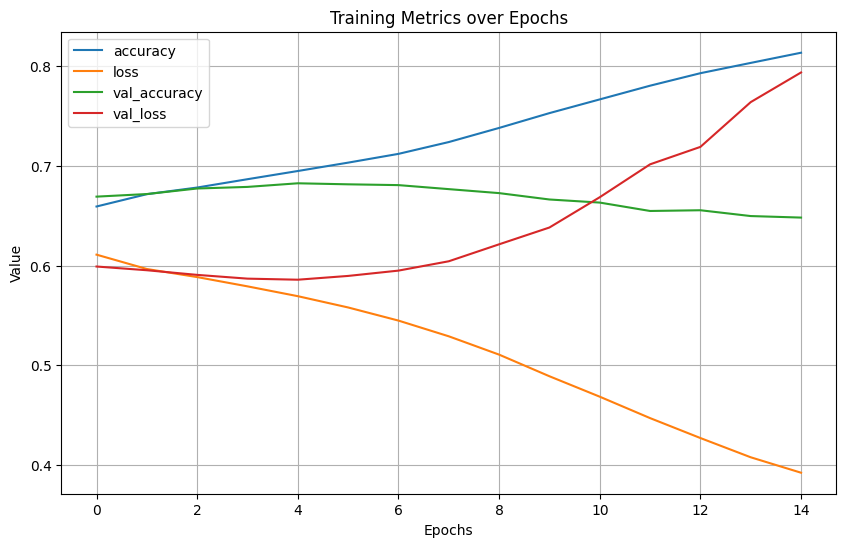

In [6]:
# This model leverages a `TextVectorization` layer and an `Embedding` layer
MODEL_NAME = "LSTM Baseline Own Embeddings"

VOCAB_SIZE = 10000
MAX_SEQ_LENGTH = 100
EMBEDDING_DIM = 256

# ---------------------------------------------------------
# The only purpose of this is to set the seeds and have same results over different runs
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
# ---------------------------------------------------------


# Build model with a TextVectorization layer and an Embedding layer
def build_model():
    """
    Build a simple LSTM model with a TextVectorization layer and an Embedding layer
    """
    # Add the vectorization layer
    vectorization_layer = layers.TextVectorization(
        max_tokens=VOCAB_SIZE,
        output_mode="int",
        output_sequence_length=MAX_SEQ_LENGTH,
    )
    train_text = train_ds.map(lambda x, y: x)  # remove labels
    vectorization_layer.adapt(train_text)

    model = models.Sequential()

    model.add(vectorization_layer)

    # Add an embedding layer
    model.add(layers.Embedding(input_dim=MAX_SEQ_LENGTH, output_dim=EMBEDDING_DIM))

    # 4. Finish building the LSM based model
    model = build_lstm_from_embedding_model(model)

    return model


# ---------------------------------------------------------


# Build the model
model = build_model()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=DEBUG,
    epochs=15,
)

# Evaluate model and print results
test_tweets, test_labels = prepare_test_ds_for_prediction(test_ds)
evaluate_model_and_print_results(model, MODEL_NAME, test_tweets, test_labels)

# Plot training history
plot_training_history(history)

## **5. Custom Preprocessing and GloVe Embeddings**

In this section, we concentrate on the second approach for the Embedding layer. In particular, we first preprocess the dataset using a custom function tailored for Twitter messages, and then tokenize words using a Keras Tokenizer. The key difference with the other configuration lies in the employed Embedding layer. In this configuration, we used pre-trained GloVe embeddings (https://nlp.stanford.edu/projects/glove/), specifically pre-trained word vectors tailored for Twitter messages (https://nlp.stanford.edu/data/glove.twitter.27B.zip), using the 200-dimensional version.

The advantage of this approach is that it leverages a pre-trained Embedding layer, allowing us to focus on deeper layers of the architecture. Additionally, this approach involves a more fine-grained preprocessing tailored specifically for Twitter messages, whereas the first approach simply utilizes the TextVectorization logic provided by Keras. However, the dataset must first go through the preprocessing and tokenization steps, which is not seamlessly integrated within the network, unlike the previous approach.

As with the previous model, we ran the model using the same 4 configurations, trying different vocabulary sizes and maximum sequence lengths. The best configuration turned out to be using <a> for `VOCAB_SIZE` and <b> for `MAX_SEQ_LENGTH`, with an accuracy of <acc>. Therefore, adopting a custom preprocessing strategy along with pre-trained word vectors proves to be a better solution. As a result, the final model will be built using this approach.


2024-12-29 01:18:03.031660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-29 01:18:05.688473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-29 01:18:08.085885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/15
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 186s 56ms/step - accuracy: 0.7476 - loss: 0.5049 - val_accuracy: 0.7891 - val_loss: 0.4434
Epoch 2/15
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 187s 57ms/step - accuracy: 0.7960 - loss: 0.4323 - val_accuracy: 0.8004 - val_loss: 0.4283
Epoch 3/15
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 187s 57ms/step - accuracy: 0.8150 - loss: 0.3979 - val_accuracy: 0.8007 - val_loss: 0.4320
Epoch 4/15
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 187s 57ms/step - accuracy: 0.8340 - loss: 0.3638 - val_accuracy: 0.7982 - val_loss: 0.4541
Epoch 5/15
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 186s 57ms/step - accuracy: 0.8555 - loss: 0.3251 - val_accuracy: 0.7937 - val_loss: 0.5029
Epoch 6/15
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 186s 57ms/step - accuracy: 0.8794 - loss: 0.2822 - val_accuracy: 0.7893 - val_loss: 0.5682
Epoch 7/15
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 186s 57ms/step - accuracy: 0.9015 - loss: 0.2355 - val_accuracy: 0.7826 - val_loss: 0.6454
Epoch 8/15
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 187s 57ms/step - accuracy: 

Evaluation Results for
 LSTM Baseline GloVe  
      Embeddings      
┏━━━━━━━━━━━┳━━━━━━━━┓
┃  Metric   ┃ Result ┃
┡━━━━━━━━━━━╇━━━━━━━━┩
│ Accuracy  │ 0.7717 │
├───────────┼────────┤
│ Precision │ 0.7565 │
├───────────┼────────┤
│  Recall   │ 0.8032 │
├───────────┼────────┤
│ F1-Score  │ 0.7791 │
└───────────┴────────┘

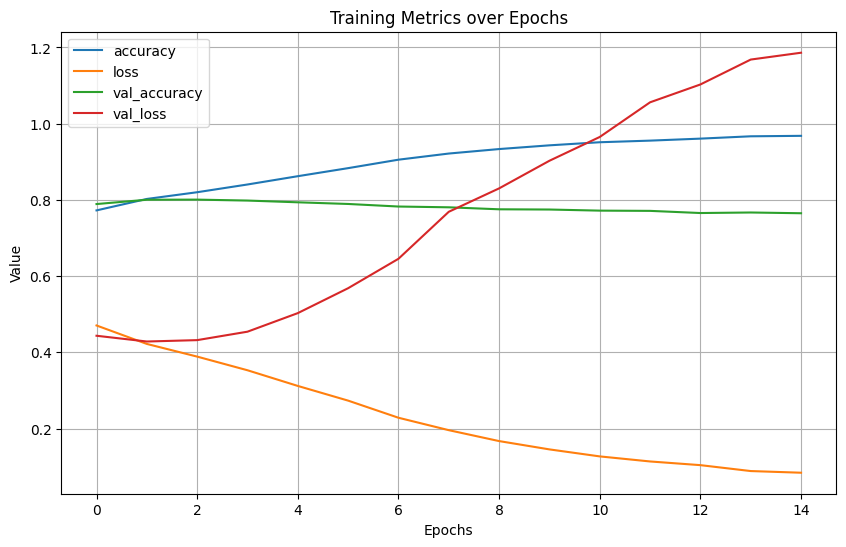

In [10]:
# This model leverages a tokenizer and pre-trained GloVe embeddings
MODEL_NAME = "LSTM Baseline GloVe Embeddings"

# ---------------------------------------------------------
# The only purpose of this is to set the seeds and have same results over different runs
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
# ---------------------------------------------------------

# GloVe Embeddings (https://nlp.stanford.edu/projects/glove/)
# ----------------------------------------------
GLOVE_FILE = "../GloVe/glove.twitter.27B.200d.txt"
GLOVE_EMBEDDING_DIM = 200
MAX_TOKENS = 10000
MAX_SEQUENCE_LENGTH = 100
# ----------------------------------------------


# Custom preprocessing for tweets, originally developed by Romain Paulus
# with minor modifications by Jeffrey Pennington. Initially implemented in Ruby,
# now adapted and refined for Python. (https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb)
def preprocess_tweet(text):
    FLAGS = re.MULTILINE | re.DOTALL

    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`-]?"

    def allcaps(text):
        text = text.group()
        return text.lower() + " "

    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    def hashtag(text):
        text = text.group()
        hashtag_body = text[1:]
        if hashtag_body.isupper():
            result = " {} ".format(hashtag_body.lower())
        else:
            result = " ".join(
                [""] + [re.sub(r"([A-Z])", r" \1", hashtag_body, flags=FLAGS)]
            )
        return result

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"/", " / ")
    text = re_sub(r"<3", "<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\S+", hashtag)
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    text = re_sub(r"([A-Z]){2,}", allcaps)

    text = re.sub(r"\s+", " ", text).strip()

    return text.lower()


# Preprocess dataset for Twitter GloVe embeddings
def preprocess_dataset(batched_ds):
    preprocessed_data = []
    labels = []

    for x, y in batched_ds.unbatch():
        preprocessed_data.append(preprocess_tweet(x.numpy().decode()))
        labels.append(y.numpy())

    preprocessed_data = np.array(preprocessed_data)
    labels = np.array(labels)

    return preprocessed_data, labels


# Load GloVe embeddings
def load_glove_embeddings(glove_file, embedding_dim):
    embeddings = {}
    with open(glove_file, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings


# Create a GloVe embedding matrix
def create_embedding_matrix(word_index, embeddings, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


# Preprocess datasets for GloVe embeddings
train_tweets, train_labels = preprocess_dataset(train_ds)
val_tweets, val_labels = preprocess_dataset(val_ds)
test_tweets, test_labels = preprocess_dataset(test_ds)

# Create and fit tokenizer on preprocessed training data
tokenizer = preprocessing.text.Tokenizer(num_words=MAX_TOKENS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_tweets)
word_index = tokenizer.word_index

# GloVe embeddings
glove_embeddings = load_glove_embeddings(GLOVE_FILE, GLOVE_EMBEDDING_DIM)
embedding_matrix = create_embedding_matrix(
    word_index, glove_embeddings, GLOVE_EMBEDDING_DIM
)

# Convert data sets to padded sequences
train_tweets = preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(train_tweets),
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
)
val_tweets = preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(val_tweets),
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
)
test_tweets = preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(test_tweets),
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
)


# Build a simple model with a pre-trained GloVe embeddings
def build_model():

    model = models.Sequential()

    model.add(layers.Input(shape=(MAX_SEQUENCE_LENGTH,)))
    # Add an embedding layer with pre-trained GloVe embeddings
    model.add(
        layers.Embedding(
            len(word_index) + 1,
            GLOVE_EMBEDDING_DIM,
            weights=[embedding_matrix],
            trainable=False,
        )
    )
    # Finish building the LSM based model
    model = build_lstm_from_embedding_model(model)

    return model


# ---------------------------------------------------------


# Build the model
model = build_model()
history = model.fit(
    train_tweets,
    train_labels,
    validation_data=(val_tweets, val_labels),
    epochs=15,
    batch_size=BATCH_SIZE,
    verbose=DEBUG,
)

# Evaluate model and print results
evaluate_model_and_print_results(model, MODEL_NAME, test_tweets, test_labels)

# Plot training history
plot_training_history(history)

## **6. The Final Bidirectional LSTM Model**

In this section, we’ll take a more fine-grained approach to build a more complex model that can better capture the structure and context of tweets. We’ll start by using pre-trained GloVe embeddings, as they turned out to be a better fit for our task. From there, we’ll design a deep architecture that combines multiple Bidirectional LSTM layers with Dense layers, while also including dropout techniques and pooling operations.

The idea behind the architecture is pretty simple: focus on capturing detailed information in the earlier layers of the network and then gradually reduce the complexity as we go deeper. This way, the model starts by learning fine-grained patterns and then refines them into more abstract representations as the layers progress.

**2 Bidirectional LSTM Layers**
The first two layers of the architecture (excluding the pre-trained Embedding layer) are Bidirectional LSTM layers. These layers are crucial for capturing the context of messages by processing the input sequence both forward and backward, providing a comprehensive understanding of the text.

To better capture sequential information, we set both layers to return sequences. This means that instead of outputting just the final hidden state of the LSTM, the layers return a hidden state for every time step in the input sequence. This allows subsequent layers to have access to the complete sequence of hidden states, preserving information from every part of the input.

In line with our approach, the second LSTM layer is designed with half the number of units compared to the first one. This follows our strategy of reducing complexity as the architecture deepens. Additionally, we apply dropout to the input units of the LSTM layers to prevent overfitting and improve the model’s ability to generalize.

**Pooling**
To summarize the sequence information into a fixed-size representation by averaging across time steps, we used a `GlobalAveragePooling1D()` layer. Its goal is to reduce the sequence dimension by calculating the average of the hidden states across all time steps. This operation condenses the temporal information into a single vector, focusing on the overall pattern of the sequence. It provides a compact and efficient representation, suitable for downstream layers in the architecture.

**Dense Layers**
For the deeper layers, we use four Dense layers to progressively abstract the features learned by the previous layers. The number of units is halved with each successive layer to reduce complexity, eventually reaching the final output layer (with a single unit) for the binary classification task.

**Dropout Layers**
To improve generalization, we apply dropout layers between each Dense layer. This should help to prevent overfitting by randomly disabling a fraction of the units during training.

To optimize some of the model's hyperparameters, we use a random search with `KerasTuner`.


In [14]:
FINAL_MODEL_NAME = "LSTM Final"
TUNING_DIR = "Tuning"
# ---------------------------------------------------------

# The only purpose of this is to set the seeds and have same results over different runs
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
# ---------------------------------------------------------


# Build Final LSTM based model
def build_model(hp):
    model = models.Sequential()

    model.add(layers.Input(shape=(100,)))
    # Add the pre-trained GloVe embedding layer
    model.add(
        layers.Embedding(
            len(word_index) + 1,
            GLOVE_EMBEDDING_DIM,
            weights=[embedding_matrix],
            trainable=False,
        )
    )

    # Tune the LSTM units and dropout rate
    lstm_units_1 = hp.Int("lstm_units_1", min_value=128, max_value=512, step=64)
    dropout_1 = hp.Float("dropout_1", min_value=0.1, max_value=0.3, step=0.1)
    dropout_2 = hp.Float("dropout_2", min_value=0.1, max_value=0.3, step=0.1)

    model.add(
        layers.Bidirectional(
            layers.LSTM(units=lstm_units_1, return_sequences=True, dropout=dropout_1)
        )
    )
    model.add(
        layers.Bidirectional(
            layers.LSTM(
                units=lstm_units_1 // 2, return_sequences=True, dropout=dropout_2
            )
        )
    )
    # Global average pooling to summarize the sequence data
    model.add(layers.GlobalAveragePooling1D())

    # Dense layers interleaved with dropout layers (tuning the dropout rate)
    dense_units_1 = lstm_units_1 // 2
    dropout_dense = hp.Float("dropout_dense", min_value=0.1, max_value=0.3, step=0.1)

    model.add(layers.Dense(dense_units_1, activation="sigmoid"))
    model.add(layers.Dropout(dropout_dense))
    model.add(layers.Dense(dense_units_1 // 2, activation="sigmoid"))
    model.add(layers.Dropout(dropout_dense))
    model.add(layers.Dense(dense_units_1 // 4, activation="sigmoid"))
    model.add(layers.Dropout(dropout_dense))
    model.add(layers.Dense(1, activation="sigmoid"))

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model
# ---------------------------------------------------------

# Tuner configuration for optimal hyperparameters
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=15,
    overwrite=True,
    directory=TUNING_DIR,
    project_name="lstm_tuning",
    seed=42,
)

# Start the search for the best hyperparameters
tuner.search(
    train_tweets,
    train_labels,
    validation_data=(val_tweets, val_tweets),
    verbose=DEBUG,
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[callbacks.EarlyStopping(patience=4)],
)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    train_tweets,
    train_labels,
    validation_data=(val_tweets, val_labels),
    verbose=DEBUG,
    epochs=150,
    batch_size=BATCH_SIZE,
    callbacks=[callbacks.EarlyStopping(patience=10)],
)

# Print best hyperparameters
print_best_hyperparameters(best_hp, FINAL_MODEL_NAME)

# Evaluate the best model on the test set and print evaluation results
evaluate_model_and_print_results(best_model, FINAL_MODEL_NAME, test_tweets, test_labels)

# Plot training history
plot_training_history(history)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
384               |384               |lstm_units_1
0.1               |0.1               |dropout_1
0.1               |0.1               |dropout_2
0.1               |0.1               |dropout_dense

Epoch 1/50
1881/3281 ━━━━━━━━━━━━━━━━━━━━ 4:22 187ms/step - accuracy: 0.5691 - loss: 0.6754

KeyboardInterrupt: 

**7. Simple Test with our own Tweets**


In [ ]:
# Our own tweets
positive_tweets = [
    "Had a great time coding today! #coding #ML",
    "Just finished a workout, feeling strong 💪 #fitness",
    "Love this new song, I reccomaned it to everyone! 🎵 #music",
    "Just got the best coffee in town ☕ #coffee #morning",
    "Watching the game tonight, LETS GOOO TEAM!! 🏀 #sports",
]

negative_tweets = [
    "I am so tired of coding, nothing seems to work! 😩 #frustrated",
    "My workout was awful today, couldn't even finish. 😔 #fitnessfail",
    "This song is terrible, why is it so popular? 😤 #musicdislike",
    "The coffee I got was horrible, it tasted burnt. 😒 #coffeeproblem",
    "The game was so boring, I almost fell asleep. 😴 #sportsfail",
]

# Combine positive and negative tweets
tweets = positive_tweets + negative_tweets
labels = [1] * len(positive_tweets) + [0] * len(negative_tweets)

# Combine tweets into one list
tweets = positive_tweets + negative_tweets

# Convert the raw tweets and labels into a TensorFlow dataset
personal_test_tweets = tf.constant(tweets)
personal_test_labels = tf.constant(labels)

# Create the test dataset
personal_test_ds = tf.data.Dataset.from_tensor_slices(
    (personal_test_tweets, personal_test_labels)
)
personal_test_ds = personal_test_ds.batch(1)

personal_test_tweets, personal_test_labels = preprocess_dataset(personal_test_ds)
personal_test_tweets = preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(personal_test_tweets),
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
)

evaluate_model_and_print_results(
    best_model, FINAL_MODEL_NAME, personal_test_tweets, personal_test_labels
)